<a href="https://colab.research.google.com/github/DarianSawali/Computer-Vision-Project-Overview/blob/main/computer_vision_yolo_augmented2.ipynb" target="_parent"><img src="https://colab.research.google.com/assets/colab-badge.svg" alt="Open In Colab"/></a>

In [ ]:
%matplotlib inline

import matplotlib
matplotlib.use('module://matplotlib_inline.backend_inline')


In [ ]:
!pip3 install -q ultralytics opencv-python
import ultralytics
ultralytics.checks()


Ultralytics 8.3.218 🚀 Python-3.13.7 torch-2.9.0 CPU (Apple M4)
Setup complete ✅ (10 CPUs, 16.0 GB RAM, 107.5/460.4 GB disk)


In [ ]:
from pathlib import Path
import yaml

data_yaml = Path.home() / "Downloads" / "TACO dataset.v1i.yolov8" / "data.yaml"
print("YAML exists:", data_yaml.exists(), "\nPath:", data_yaml)

with open(data_yaml, "r") as f:
    y = yaml.safe_load(f)

print("nc:", y.get("nc"))
print("names:", y.get("names"))

YAML exists: True 
Path: /Users/darianaxelsawali/Downloads/TACO dataset.v1i.yolov8/data.yaml
nc: 6
names: ['cardboard', 'glass', 'metal', 'other', 'paper', 'plastic']


In [ ]:
from ultralytics import YOLO
import torch

device = "mps" if torch.backends.mps.is_available() else "cpu"
print("Using device:", device)

Using device: mps


In [ ]:
from pathlib import Path

for split in ["train", "valid", "test"]:
    p = Path("/Users/darianaxelsawali/Downloads/TACO dataset.v1i.yolov8")/split/"labels.cache"
    if p.exists():
        p.unlink()
        print("Deleted:", p)


Deleted: /Users/darianaxelsawali/Downloads/TACO dataset.v1i.yolov8/train/labels.cache
Deleted: /Users/darianaxelsawali/Downloads/TACO dataset.v1i.yolov8/valid/labels.cache
Deleted: /Users/darianaxelsawali/Downloads/TACO dataset.v1i.yolov8/test/labels.cache


In [ ]:
from pathlib import Path
import numpy as np
from collections import Counter
import yaml, re

root = Path("/Users/darianaxelsawali/Downloads/TACO dataset.v1i.yolov8")


data = yaml.safe_load((root/"data.yaml").read_text())
names = data.get("names", {})
if isinstance(names, list):
    names = {i:n for i,n in enumerate(names)}

def count_labels(lbl_dir: Path):
    c = Counter()
    for f in lbl_dir.rglob("*.txt"):
        for line in f.read_text().strip().splitlines():
            m = re.match(r"^\s*(\d+)", line)
            if m:
                c[int(m.group(1))] += 1
    return c

train_counts = count_labels(root/"train"/"labels")
val_counts   = count_labels(root/"valid"/"labels")
all_counts = train_counts + val_counts

total = sum(all_counts.values())
print("Per-class box counts:")
for cid in sorted(all_counts):
    print(f"{cid:>2} {names.get(cid, str(cid)):<10} {all_counts[cid]:>5}  ({all_counts[cid]/total:6.2%})")

max_id = max(all_counts) if all_counts else -1
counts_vec = np.array([all_counts.get(i,0) for i in range(max_id+1)])
counts_vec


Per-class box counts:
 0 cardboard    539  (13.96%)
 1 glass        140  ( 3.63%)
 2 metal        538  (13.93%)
 3 other         36  ( 0.93%)
 4 paper        509  (13.18%)
 5 plastic     2100  (54.38%)


array([ 539,  140,  538,   36,  509, 2100])

In [ ]:
from pathlib import Path
from collections import defaultdict, Counter
import math, numpy as np

root = Path("Downloads/TACO dataset.v1i.yolov8")
img_dir = root/"train"/"images"
lbl_dir = root/"train"/"labels"


img2cls = defaultdict(set)
for lbl in lbl_dir.rglob("*.txt"):
    stem = lbl.stem
    img = (img_dir/f"{stem}.jpg")
    if not img.exists(): img = (img_dir/f"{stem}.png")
    if not img.exists(): continue
    for line in lbl.read_text().splitlines():
        line = line.strip()
        if not line: continue
        cid = int(line.split()[0])
        img2cls[img].add(cid)

totals = {0:539, 1:140, 2:538, 3:36, 4:509, 5:2100}

target = totals[5]
raw_weights = {cid: math.ceil(target/max(1,totals[cid])) for cid in totals}

cap = 6
weights = {cid: min(cap, w) for cid, w in raw_weights.items()}

oversampled = []
for img, classes in img2cls.items():
    w = max(weights.get(c,1) for c in classes)
    oversampled.extend([str(img.resolve())]*w)

txt = root/"train_oversampled.txt"
unique = sorted(set(oversampled))
txt.write_text("\n".join(unique))
print("Wrote:", txt, f"({len(unique)} unique images, {len(oversampled)} total entries with repeats)")

print("Weights used:", weights)


Wrote: Downloads/TACO dataset.v1i.yolov8/train_oversampled.txt (1491 unique images, 4424 total entries with repeats)
Weights used: {0: 4, 1: 6, 2: 4, 3: 6, 4: 5, 5: 1}


In [ ]:
from ultralytics import YOLO

model = YOLO("yolov8s.pt")

model.train(
    data="/Users/darianaxelsawali/Downloads/TACO dataset.v1i.yolov8/data.yaml",
    epochs=10,
    imgsz=640,
    batch=8,
    device="mps",

    optimizer="AdamW",
    lr0=0.002, lrf=0.01,
    cos_lr=True,
    patience=5,

    cls=1.0,
    box=7.5, dfl=1.5,

    mosaic=1.0, close_mosaic=10,
    copy_paste=0.4, copy_paste_mode="flip",
    mixup=0.15,
    hsv_h=0.02, hsv_s=0.7, hsv_v=0.4,
    fliplr=0.5, flipud=0.05,
    degrees=5.0, shear=2.0, translate=0.08, scale=0.5,
    erasing=0.5, auto_augment="randaugment",

    workers=0,
    project="runs/detect", name="train_balanced_10e"
)


New https://pypi.org/project/ultralytics/8.3.223 available 😃 Update with 'pip install -U ultralytics'
Ultralytics 8.3.218 🚀 Python-3.13.7 torch-2.9.0 MPS (Apple M4)
engine/trainer: agnostic_nms=False, amp=True, augment=False, auto_augment=randaugment, batch=8, bgr=0.0, box=7.5, cache=False, cfg=None, classes=None, close_mosaic=10, cls=1.0, compile=False, conf=None, copy_paste=0.4, copy_paste_mode=flip, cos_lr=True, cutmix=0.0, data=/Users/darianaxelsawali/Downloads/TACO dataset.v1i.yolov8/data.yaml, degrees=5.0, deterministic=True, device=mps, dfl=1.5, dnn=False, dropout=0.0, dynamic=False, embed=None, epochs=10, erasing=0.5, exist_ok=False, fliplr=0.5, flipud=0.05, format=torchscript, fraction=1.0, freeze=None, half=False, hsv_h=0.02, hsv_s=0.7, hsv_v=0.4, imgsz=640, int8=False, iou=0.7, keras=False, kobj=1.0, line_width=None, lr0=0.002, lrf=0.01, mask_ratio=4, max_det=300, mixup=0.15, mode=train, model=yolov8s.pt, momentum=0.937, mosaic=1.0, multi_scale=False, name=train_balanced_10e

ultralytics.utils.metrics.DetMetrics object with attributes:

ap_class_index: array([0, 1, 2, 3, 4, 5])
box: ultralytics.utils.metrics.Metric object
confusion_matrix: <ultralytics.utils.metrics.ConfusionMatrix object at 0x137ecd8b0>
curves: ['Precision-Recall(B)', 'F1-Confidence(B)', 'Precision-Confidence(B)', 'Recall-Confidence(B)']
curves_results: [[array([          0,    0.001001,    0.002002,    0.003003,    0.004004,    0.005005,    0.006006,    0.007007,    0.008008,    0.009009,     0.01001,    0.011011,    0.012012,    0.013013,    0.014014,    0.015015,    0.016016,    0.017017,    0.018018,    0.019019,     0.02002,    0.021021,    0.022022,    0.023023,
          0.024024,    0.025025,    0.026026,    0.027027,    0.028028,    0.029029,     0.03003,    0.031031,    0.032032,    0.033033,    0.034034,    0.035035,    0.036036,    0.037037,    0.038038,    0.039039,     0.04004,    0.041041,    0.042042,    0.043043,    0.044044,    0.045045,    0.046046,    0.047047,
        

In [ ]:
from ultralytics import YOLO
import matplotlib.pyplot as plt

model = YOLO("/Users/darianaxelsawali/runs/detect/train_balanced_10e/weights/best.pt")


results = model.val(
    data="/Users/darianaxelsawali/Downloads/TACO dataset.v1i.yolov8/data.yaml",
    split="val",
    imgsz=480,
    device="mps",
    plots=True
)

print("Curves regenerated. Check:", results.save_dir)


Ultralytics 8.3.218 🚀 Python-3.13.7 torch-2.9.0 MPS (Apple M4)
Model summary (fused): 72 layers, 11,127,906 parameters, 0 gradients, 28.4 GFLOPs
val: Fast image access ✅ (ping: 0.0±0.0 ms, read: 2111.7±150.5 MB/s, size: 1943.5 KB)
val: Scanning /Users/darianaxelsawali/Downloads/TACO dataset.v1i.yolov8/valid/labels.cache... 199 images, 4 backgrounds, 0 corrupt: 100% ━━━━━━━━━━━━ 199/199 547.0Kit/s 0.0s
                 Class     Images  Instances      Box(P          R      mAP50  mAP50-95): 100% ━━━━━━━━━━━━ 13/13 0.3it/s 45.0s
                   all        199        357      0.446      0.229     0.0989     0.0581
             cardboard         15         18     0.0705      0.222     0.0564     0.0343
                 glass         14         26          1          0     0.0185    0.00844
                 metal         39         79      0.234      0.392      0.188      0.113
                 other         11         12          1          0     0.0152    0.00637
                 paper

In [ ]:
from pathlib import Path

RUN_DIR = Path("runs/detect/train_balanced_10e")
WEIGHTS = RUN_DIR / "weights" / "best.pt"

DATA_YAML = Path("/Users/darianaxelsawali/Downloads/TACO dataset.v1i.yolov8/data.yaml")

print("Run dir exists:", RUN_DIR.exists())
print("Best weights exist:", WEIGHTS.exists())
print("Data YAML exists:", DATA_YAML.exists())


Run dir exists: True
Best weights exist: True
Data YAML exists: True


In [ ]:
from pathlib import Path
import shutil

run_dir = Path("runs/detect/train_balanced_10e")
export_dir = Path("/Users/darianaxelsawali/Desktop/YOLO_Augmented2_Export")
export_dir.mkdir(parents=True, exist_ok=True)

for fname in ["confusion_matrix.png", "BoxPR_curve.png", "BoxF1_curve.png", "results.png"]:
    src = run_dir / fname
    if src.exists():
        shutil.copy(src, export_dir / fname)
        print("Exported:", export_dir / fname)
    else:
        print("Missing:", src)



Exported: /Users/darianaxelsawali/Desktop/YOLO_Augmented2_Export/confusion_matrix.png
Exported: /Users/darianaxelsawali/Desktop/YOLO_Augmented2_Export/BoxPR_curve.png
Exported: /Users/darianaxelsawali/Desktop/YOLO_Augmented2_Export/BoxF1_curve.png
Exported: /Users/darianaxelsawali/Desktop/YOLO_Augmented2_Export/results.png


Export dir: /Users/darianaxelsawali/Desktop/YOLO_Augmented2_Export exists: True


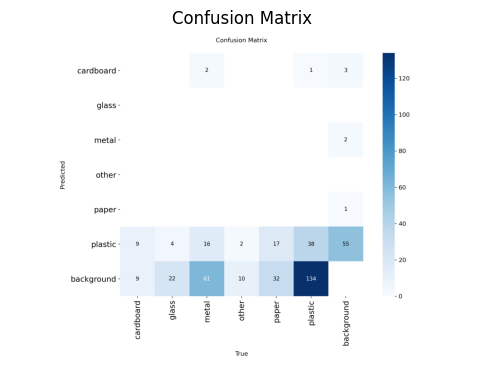

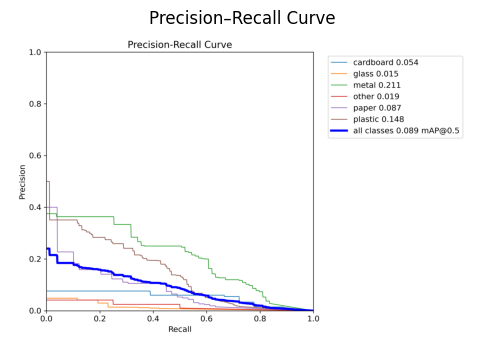

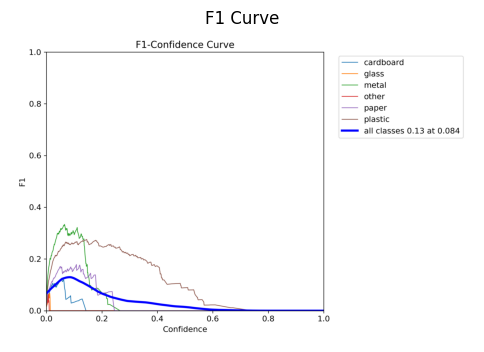

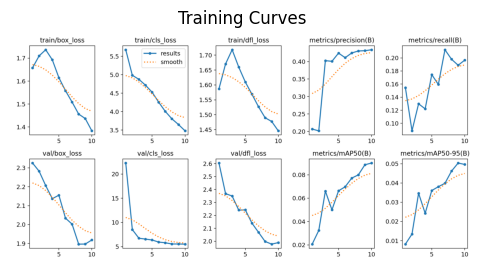

In [ ]:
from pathlib import Path
from PIL import Image
import matplotlib.pyplot as plt

export_dir = Path.cwd() / "Desktop" / "YOLO_Augmented2_Export"
print("Export dir:", export_dir, "exists:", export_dir.exists())

for name, title in [
    ("confusion_matrix.png", "Confusion Matrix"),
    ("BoxPR_curve.png", "Precision–Recall Curve"),
    ("BoxF1_curve.png", "F1 Curve"),
    ("results.png", "Training Curves"),
]:
    p = export_dir / name
    if p.exists():
        plt.figure(figsize=(6,6))
        plt.imshow(Image.open(p).convert("RGB")); plt.axis("off"); plt.title(title)
        plt.show()
    else:
        print("Not found:", p)


In [ ]:
from ultralytics import YOLO
from pathlib import Path

weights = "runs/detect/train_balanced_10e/weights/best.pt"
model = YOLO(weights)

img_src = "/Users/darianaxelsawali/Downloads/TACO dataset.v1i.yolov8/valid/images"
for c in [0.15, 0.25, 0.35]:
    name = f"val2_preds_conf{int(c*100)}"
    preds = model.predict(
        source=img_src,
        imgsz=480,
        conf=c,
        iou=0.6,
        max_det=100,
        device="mps",
        save=True,
        project="runs/preds",
        name=name
    )
    print("Saved:", preds[0].save_dir)



image 1/199 /Users/darianaxelsawali/Downloads/TACO dataset.v1i.yolov8/valid/images/000000_JPG.rf.3ea0602baa7b341ebd5cba44d32ec453.jpg: 480x384 1 plastic, 3377.5ms
image 2/199 /Users/darianaxelsawali/Downloads/TACO dataset.v1i.yolov8/valid/images/000000_jpg.rf.239416263fc44e304fad0f1f21bbeb47.jpg: 384x480 1 plastic, 2754.2ms
image 3/199 /Users/darianaxelsawali/Downloads/TACO dataset.v1i.yolov8/valid/images/000000_jpg.rf.785c52fe2311d0fd19da7a7894d5b5d6.jpg: 384x480 (no detections), 40.8ms
image 4/199 /Users/darianaxelsawali/Downloads/TACO dataset.v1i.yolov8/valid/images/000000_jpg.rf.d7a448b5668666901c05fbe1325dfc5a.jpg: 224x480 1 plastic, 3205.6ms
image 5/199 /Users/darianaxelsawali/Downloads/TACO dataset.v1i.yolov8/valid/images/000001_JPG.rf.01b5c9a848b153df9f2df2f9c6ce21ad.jpg: 480x384 2 plastics, 373.2ms
image 6/199 /Users/darianaxelsawali/Downloads/TACO dataset.v1i.yolov8/valid/images/000002_jpg.rf.846b02ab844804f8a299e5eb56b75829.jpg: 384x480 (no detections), 29.0ms
image 7/199 /

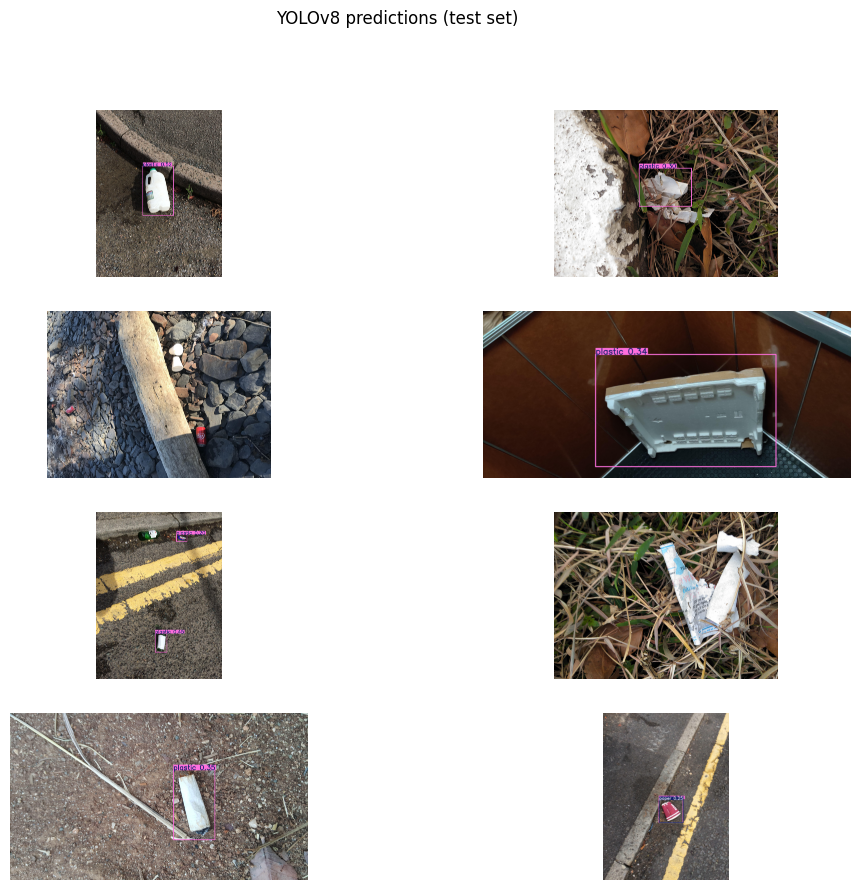

In [ ]:
from PIL import Image
import matplotlib.pyplot as plt

viz = Path("runs/preds/val2_preds_conf15")
imgs = sorted(viz.glob("*.*"))[:8]
plt.figure(figsize=(12, 10))
for i,p in enumerate(imgs,1):
    plt.subplot(4,2,i); plt.imshow(Image.open(p)); plt.axis("off")
plt.suptitle("YOLOv8 predictions (test set)")
plt.show()


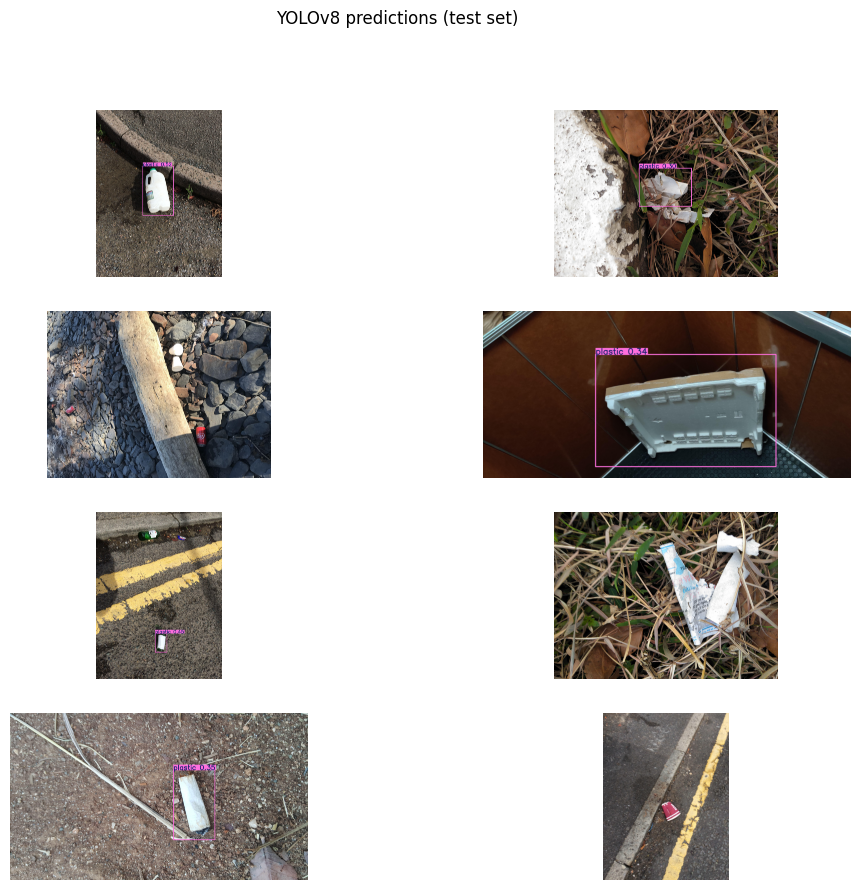

In [ ]:
from PIL import Image
import matplotlib.pyplot as plt

viz = Path("runs/preds/val2_preds_conf25")
imgs = sorted(viz.glob("*.*"))[:8]
plt.figure(figsize=(12, 10))
for i,p in enumerate(imgs,1):
    plt.subplot(4,2,i); plt.imshow(Image.open(p)); plt.axis("off")
plt.suptitle("YOLOv8 predictions (test set)")
plt.show()


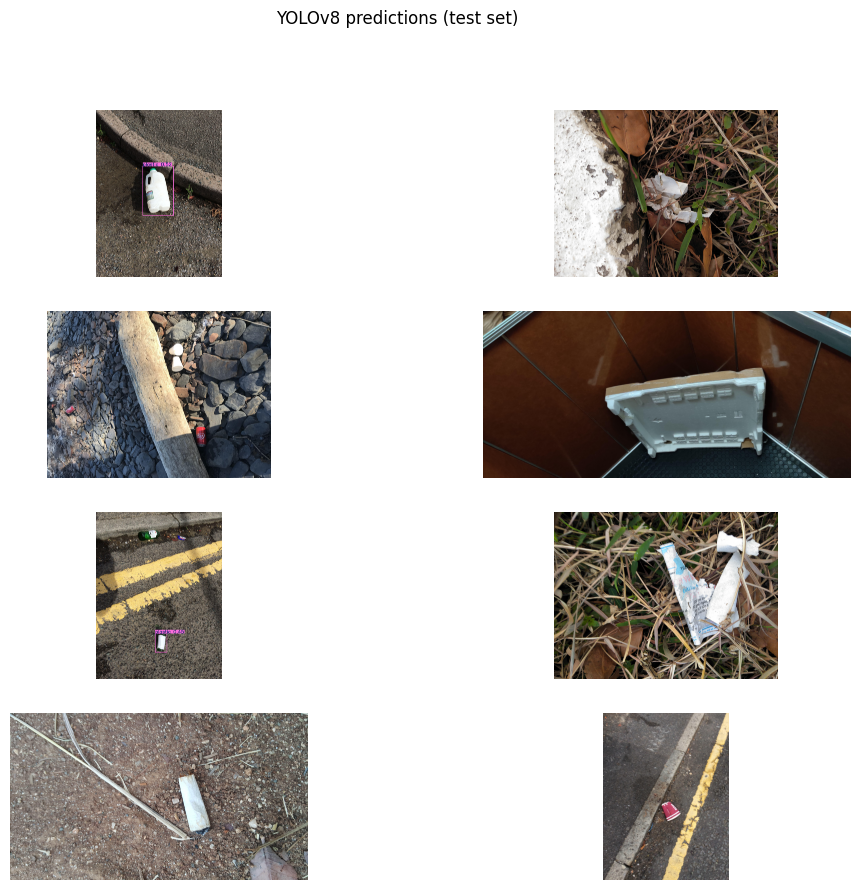

In [ ]:
from PIL import Image
import matplotlib.pyplot as plt

viz = Path("runs/preds/val2_preds_conf35")
imgs = sorted(viz.glob("*.*"))[:8]
plt.figure(figsize=(12, 10))
for i,p in enumerate(imgs,1):
    plt.subplot(4,2,i); plt.imshow(Image.open(p)); plt.axis("off")
plt.suptitle("YOLOv8 predictions (test set)")
plt.show()


In [ ]:
import shutil
from pathlib import Path

src = Path("/Users/darianaxelsawali/runs")
dst = Path("/Users/darianaxelsawali/Desktop/YOLO_Runs_Backup_Augmented2_copy")
shutil.copytree(src, dst, dirs_exist_ok=True)
print("Copied to:", dst)


Copied to: /Users/darianaxelsawali/Desktop/YOLO_Runs_Backup_Augmented2_copy
